# Paper Implementation
## END-TO-END TRAINED CNN ENCODER-DECODER NETWORKS FOR IMAGE STEGANOGRAPHY - Atique </i> $et.al$
## Tensorflow 2.0
###  Notebook Author: Saad Zia

In [1]:
import numpy as np
import tensorflow as tf
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display


%load_ext autoreload
%autoreload 2

#### Setting up Data Pipeline

In [2]:
(x, y), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
payload_train = x
host_train = x[np.random.choice(np.arange(x.shape[0]), size=payload_train.shape[0])]

payload_test = x_test
host_test = x_test[np.random.choice(np.arange(x_test.shape[0]), size=payload_test.shape[0])]

In [36]:
# Instantiate the Dataset class
train_dataset = tf.data.Dataset.from_tensor_slices(((payload_train, host_train), (payload_train, host_train)))

In [5]:
# Normalization function
def normalize(payload, host):
    (input_payload, input_host), (label_payload, label_host)
    payload = tf.image.per_image_standardization(payload)
    host = tf.image.per_image_standardization(host)
    return payload, host

def resize(payload, host)
# Adding shuffle, normalization and batching operations to the dataset object
train_dataset = (train_dataset
                 .map(normalize)
                 .shuffle(50000)
                 .batch(128, drop_remainder=True))

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [ ]:
train_dataset.map()

In [6]:
# Instantiate the test Dataset class
test_dataset = tf.data.Dataset.from_tensor_slices((payload_test, host_test))
test_dataset = (test_dataset.map(normalize).batch(128, drop_remainder=True))

#### Setting up tf.keras Model

In [20]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

In [21]:
from encoder import EncoderNetwork
from decoder import DecoderNetwork

In [22]:
encoder_network = EncoderNetwork()
decoder_network = DecoderNetwork()

In [23]:
carrier_image_shape=(32, 32, 3)
payload_image_shape=(32, 32, 1)

input_carrier = Input(shape=carrier_image_shape, name='input_carrier')
input_payload = Input(shape=payload_image_shape, name='input_payload')

In [24]:
encoded_output = encoder_network.get_network(input_carrier, input_payload)
decoded_output = decoder_network.get_network(encoded_output)

In [25]:
steganography_model = Model(inputs=[input_carrier, input_payload], outputs=[encoded_output, decoded_output])

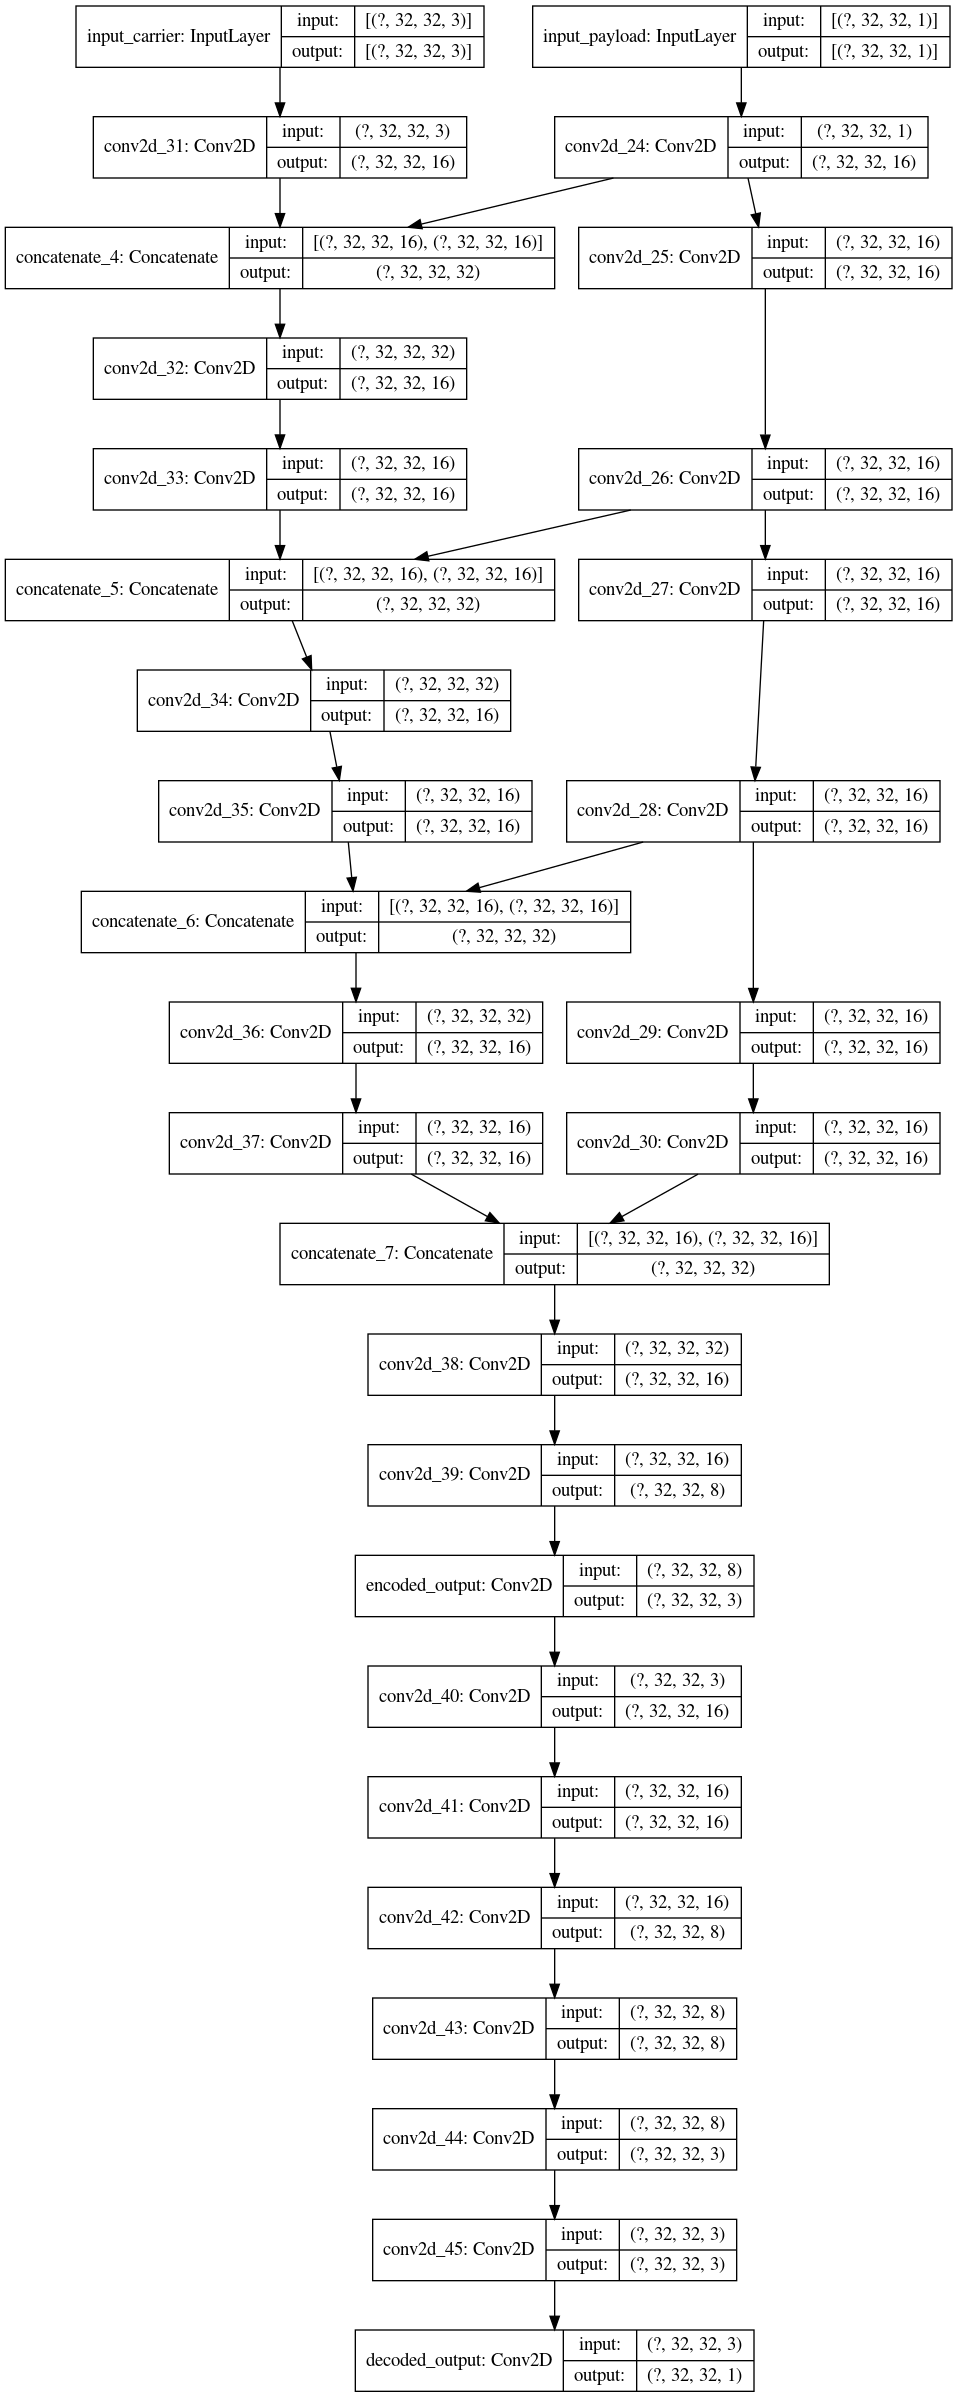

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(steganography_model, show_shapes=True)

In [27]:
steganography_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_carrier (InputLayer)      [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_payload (InputLayer)      [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 32, 32, 16)   448         input_carrier[0][0]              
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 32, 32, 16)   160         input_payload[0][0]              
____________________________________________________________________________________________

In [28]:
# Defining Loss Function

def loss_function(payload, host, encoder_output, decoder_output):
    
    def loss(y_true,y_pred):
        tf.math.reduce_mean(tf.math.squared_difference(payload, decoder_output)\
                               + tf.math.squared_difference(host, encoder_output))
        y_pred, pred_matrix = y_pred
        
    return loss


In [29]:
def custom_loss(input_):
    def loss(y_true, y_pred):
        return tf.math.reduce_mean(tf.math.squared_difference(y_true, y_pred))
    return loss             

In [30]:
steganography_model.compile(
          loss={'encoded_output': custom_loss(input_carrier), 'decoded_output': custom_loss(input_payload)},\
        loss_weights={'encoded_output': 1, 'decoded_output': 1},\
          optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [32]:
steganography_model.fit(train_dataset)

      1/Unknown - 0s 131ms/step

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [<tf.Tensor 'IteratorGetNext:0' shape=(128, 32, 32, 3) dtype=uint8>]...

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()